In [1]:
import torch
import torch.distributions as tdist
rnorm = tdist.Normal(torch.tensor([0.]), torch.tensor([1]))
from torch.autograd import Function
import numpy as np
from sksparse.cholmod import cholesky
from math import sqrt 
class Scipy_SolveCholesky(Function):

# Cholesky decomposition of sparse matrices

    @staticmethod
    def forward(self, torch_sparsematrix, dt, perm=False):
        # cast torch_sparsematrix to scipy sparse csc matrix 
        sp_sparsematrix = scsp.csc_matrix((torch_sparsematrix.detach().cpu().coalesce().values(),
                                           torch_sparsematrix.detach().cpu().coalesce().indices()),
                                          shape=(torch_sparsematrix.shape[0],torch_sparsematrix.shape[0]))

        A = scsp.identity(sp_sparsematrix.shape[0])+\
            (dt* (scsp.csc_matrix.transpose(sp_sparsematrix) @ sp_sparsematrix) )
        #A = sp_sparsematrix
        
        # Cholesky decomposition with permutation A=P'LL'P
        if perm==True:
            AspChol = cholesky(A)
            # save input requires for backward (A here from Ax=b) and
            self.save_for_backward( torch.tensor(AspChol.P()), torch.tensor(AspChol.L()) )
        else:
            # Cholesky decomposition without permutation A=L'L
            AspChol = cholesky(A,ordering_method="natural")
            # save input requires for backward (A here from Ax=b) and
            Lcoo = AspChol.L().tocoo()
            L = torch.sparse.FloatTensor(torch.LongTensor([Lcoo.row.tolist(), Lcoo.col.tolist()]),
                                                torch.FloatTensor(Lcoo.data))
            self.save_for_backward(L)

        return torch.as_tensor(L, dtype=torch_sparsematrix.dtype)

from torch_sparse.tensor import SparseTensor
from torch_sparse.matmul import matmul as matmul2


def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size)
    if len(val.size())==0:
        values = (val.expand(size))
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size]))

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.FloatTensor(size*n1,size*n2)

def spspmm(A,B):
    """Matrix product of two sparse tensors. Both input sparse matrices need to
    be coalesced (use the :obj:`coalesced` attribute to force).
    Args:
        indexA (:class:`LongTensor`): The index tensor of first sparse matrix.
        valueA (:class:`Tensor`): The value tensor of first sparse matrix.
        indexB (:class:`LongTensor`): The index tensor of second sparse matrix.
        valueB (:class:`Tensor`): The value tensor of second sparse matrix.
        m (int): The first dimension of first corresponding dense matrix.
        k (int): The second dimension of first corresponding dense matrix and
            first dimension of second corresponding dense matrix.
        n (int): The second dimension of second corresponding dense matrix.
        coalesced (bool, optional): If set to :obj:`True`, will coalesce both
            input sparse matrices. (default: :obj:`False`)
    :rtype: (:class:`LongTensor`, :class:`Tensor`)
    """

    indexA = A.detach().cpu().coalesce().indices()
    valueA = A.detach().cpu().coalesce().values()
    indexB = B.detach().cpu().coalesce().indices()
    valueB = B.detach().cpu().coalesce().values()
    m = A.size()[0]
    k = A.size()[1]
    n = B.size()[1]

    coalesced =True

    A2 = SparseTensor(row=indexA[0], col=indexA[1], value=valueA,
                     sparse_sizes=(m, k), is_sorted=not coalesced)
    B2 = SparseTensor(row=indexB[0], col=indexB[1], value=valueB,
                     sparse_sizes=(k, n), is_sorted=not coalesced)
    
    C = matmul2(A2, B2)
    row, col, value = C.coo()
    indexC = torch.stack([row, col], dim=0)
    valueC = value

    return torch.sparse.FloatTensor(indexC.long(), valueC, torch.Size([m,n]))

/home/administrateur/anaconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### Paramètres de simulation
######## Taille du domaine
resolution=5
Nx=Ny=10*resolution;
nbNodes=Nx*Ny
######## Espace entre les noeuds
dx=dy=1;
######## Paramètre kappa
kappa=1/3;

### Global anisotropy

\begin{eqnarray*}
(\kappa^2-\nabla \cdot H\nabla)^{\frac{\alpha}{2}}\mathbf{x}(\mathbf{s})=\tau\mathcal{W}(\mathbf{s})
\end{eqnarray*}

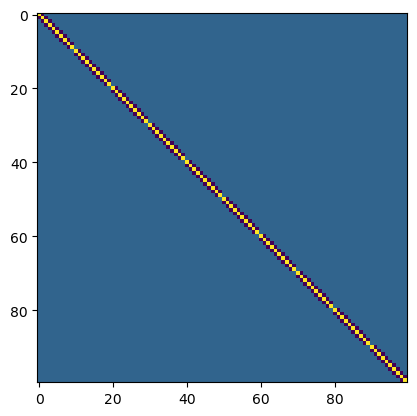

In [3]:
import matplotlib
import matplotlib.pyplot as plt

def DiffOperator(Nx, Ny, dx, dy, H, kappa):

    nbNodes = Nx * Ny
    H11=H[0,0] ; H12=H[0,1] ; H21=H[1,0] ; H22=H[0,1]  
    nbNodes=Nx*Ny

    indices = torch.arange(0,nbNodes)
    ## Voisin à droite Points de la grille concernés : Retrait du bord droit
    index = torch.where(torch.fmod(indices+1,Nx) != 0)[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k1 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + 1, (-1*H11/(dx**2)).repeat_interleave(N) ))
    ## Voisin à gauche Points de la grille concernés : Retrait du bord gauche
    index = torch.where(torch.fmod(indices+1,Nx) != 1)[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k2 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - 1, (-1*H11/(dx**2)).repeat_interleave(N) ))
    ## Voisin du haut Points de la grille concernés : Retrait du bord haut
    index = torch.where((indices+1) <= (Ny-1)*Nx )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k3 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx, (-1*H22/(dx**2)).repeat_interleave(N) ))
    ## Voisin du bas Points de la grille concernés : Retrait du bord bas
    index = torch.where((indices+1) >= (Nx+1) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k4 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx, (-1*H22/(dx**2)).repeat_interleave(N) ))
    ## Voisin en haut à droite Points de la grille concernés : Retrait du bord haut et droit
    index = torch.where( (torch.fmod(indices+1,Nx) != 0) & ((indices+1)<= (Ny-1)*Nx) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k5 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx+1, ((H12+H21)/(4*dx*dy)).repeat_interleave(N) ))
    ## Voisin en haut à gauche Points de la grille concernés : Retrait du bord haut et gauche
    index = torch.where( (torch.fmod(indices+1,Nx) != 1) & ((indices+1)<= (Ny-1)*Nx) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k6 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx-1, (-1*(H12+H21)/(4*dx*dy)).repeat_interleave(N) ))
    ## Voisin en bas à droite Points de la grille concernés : Retrait du bord bas et droit
    index = torch.where( (torch.fmod(indices+1,Nx) != 0) & ((indices+1)>=(Nx+1)) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k7 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx+1, (-1*(H12+H21)/(4*dx*dy)).repeat_interleave(N) ))
    ## Voisin en bas à gauche Points de la grille concernés : Retrait du bord bas et gauche
    index = torch.where( (torch.fmod(indices+1,Nx) != 1) & ((indices+1)>=(Nx+1)) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k8 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx-1, ((H12+H21)/(4*dx*dy)).repeat_interleave(N) ))
    ## Point central
    N=len(indices)
    k9 = torch.stack((indices.double(), indices.double(), (kappa**2 + 2*(H11/(dx**2) + H22/(dy**2))).repeat_interleave(N) ))
    ## Tous les voisins
    k = torch.cat((k1, k2, k3, k4, k5, k6, k7, k8, k9),dim=1)
    return(torch.sparse.FloatTensor(k[0:2].long(), k[2], torch.Size([nbNodes,nbNodes])))

#### Test de la fonction
A=DiffOperator(10,10,1,1,H=torch.tensor(np.array([[1,0],[0,1]])),kappa=1/3)
plt.imshow(A.to_dense().numpy())

In [4]:
from IPython import display

import scipy.sparse as scsp
from sksparse.cholmod import cholesky

A=DiffOperator(Nx,Ny,dx,dy,torch.tensor(np.array([[1,1],[1,1]])),0.03)

######## Temps total de la simulation
tps=100
######## Pas de temps
dt=1
######## Nombre d'itérations
nbIter=int(tps/dt)
######## Nombre d'itérations à sauter entre deux affichages
nbSkip=1

# ----------------------------------------------------------------------------------------- #

#### Décomposition de Cholesky de la matrice du système linéaire
L = Scipy_SolveCholesky.apply(A,dt)
Achol = torch.tensor(np.dot(L.to_dense().numpy(),np.transpose(L.to_dense().numpy())))

/tmp/ipykernel_14987/2636535447.py:30: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  AspChol = cholesky(A,ordering_method="natural")


In [5]:
import imageio
import os 

nsteps=10

Id = sparse_eye(nbNodes)

# Initialisation  
Z_all = [torch.randn(nbNodes)]
P_all = [torch.eye(nbNodes,nbNodes)]
#P_all = [torch.linalg.inv(spspmm(B.t(),B).to_dense()).float()]

def run_simulation(i,Z_all):
  print(i)
  theta =  np.pi + (np.pi)*2*i/100  
  A=DiffOperator(Nx,Ny,dx,dy,torch.tensor(np.array([[np.cos(theta),np.sin(theta)],
                                                    [np.sin(theta),np.cos(theta)]])),0.33)  
  B=spspmm(A,A)
  B=(1./2)*(B+B.t())
  M = Id+dt*B
  M = torch.linalg.inv(M.to_dense()).float()
  L = Scipy_SolveCholesky.apply(A,dt)

  #### Calcul du second membre
  RM=torch.flatten(sqrt(dt/(dx*dy))*rnorm.sample((nbNodes,)))+torch.flatten(Z_all[i])
  Z = torch.triangular_solve(torch.unsqueeze(torch.unsqueeze(RM,dim=1),dim=0).float(),
                              torch.tril(torch.unsqueeze(L.to_dense(),dim=0)).float(),
                              upper=False)
  Z = torch.triangular_solve(Z[0],
                              torch.transpose(torch.tril(torch.unsqueeze(L.to_dense(),dim=0)).float(),1,2),
                              upper=True)
  Z = torch.flatten(Z[0])
  P = torch.matmul(M,torch.matmul(P_all[i]+torch.eye(nbNodes,nbNodes).float(),torch.t(M)))
  Z_all.append(Z)
  P_all.append(P)
  plt.imshow(Z.numpy().reshape(Nx,Ny),vmin=-2,vmax=2)
  return Z_all

filenames = []
for i in range(nsteps):
    plt.cla()
    Z_all = run_simulation(i,Z_all)
    filename = f'{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)
    plt.close()
    
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
    
Z_all = torch.stack(Z_all,dim=0)
P_all = torch.stack(P_all,dim=0)

0


/tmp/ipykernel_14987/2636535447.py:30: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  AspChol = cholesky(A,ordering_method="natural")
/tmp/ipykernel_14987/1410427852.py:26: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Z = torch.triangular_solve(torch.unsqueeze(torch.unsqueeze(RM,dim=1),dim=0).float(),


1
2
3
4
5
6
7
8
9


/tmp/ipykernel_14987/1410427852.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [7]:
import xarray as xr
data = xr.Dataset(coords={'lon':np.arange(50),'lat':np.arange(50),'time':np.arange(nsteps+1)},
                  data_vars={'gp':(('time','lat','lon'),np.reshape(Z_all.numpy(),(nsteps+1,50,50)))})

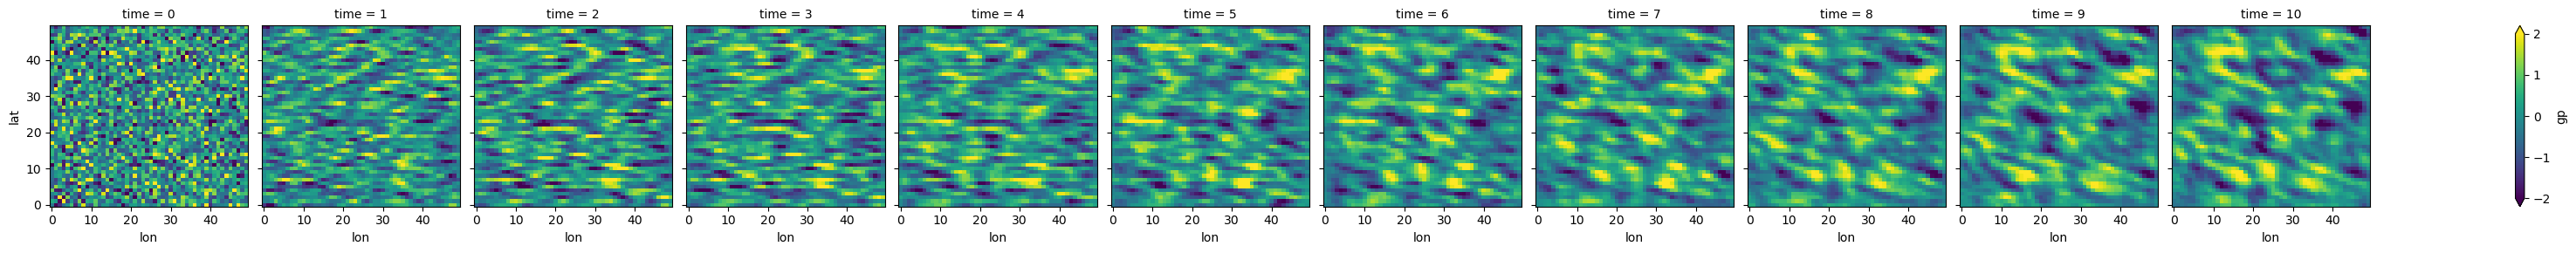

In [8]:
data.gp.plot(col='time',col_wrap=nsteps+1,vmin=-2,vmax=2)

In [13]:
# Initialisation
Z_all_new = [Z_all[-1]]


def reverse_process(i,xt,Pt):

  print(i)
  theta =  np.pi + (np.pi)*2*(i+1)/100  
  A=DiffOperator(Nx,Ny,dx,dy,torch.tensor(np.array([[np.cos(theta),np.sin(theta)],
                                                    [np.sin(theta),np.cos(theta)]])),0.33) 

  B=spspmm(A,A).float()
  B=(1./2)*(B+B.t())
  M = Id+dt*B
  M = torch.linalg.inv(M.to_dense()).float()
  G = M

  z = rnorm.sample((nbNodes,))
  Gw = torch.squeeze(torch.matmul(M,z))
  #fx = torch.squeeze(torch.matmul(M,xt) - (1./2)*torch.matmul(torch.matmul(torch.matmul(G,torch.t(G)),torch.linalg.inv(Pt)),xt))
  fx = torch.squeeze(1.*torch.matmul(torch.matmul(Id,M),xt) + (1./2)*torch.matmul(torch.matmul(G,torch.t(G)),torch.linalg.solve(Pt,xt)))
  xtm1 = torch.squeeze(xt) + fx + Gw
  return xtm1

xt = torch.unsqueeze(Z_all[nsteps],dim=1)
for i in range(nsteps,0,-1):
    if i>1:
        Pt = P_all[i-1]
        xt = reverse_process(i,xt,Pt)
    else:
        Pt = P_all[0]
        xt = torch.squeeze(rnorm.sample((nbNodes,1)))
    Z_all_new.append(xt) 
        
Z_all_new = torch.stack(Z_all_new)

10
9
8
7
6
5
4
3
2


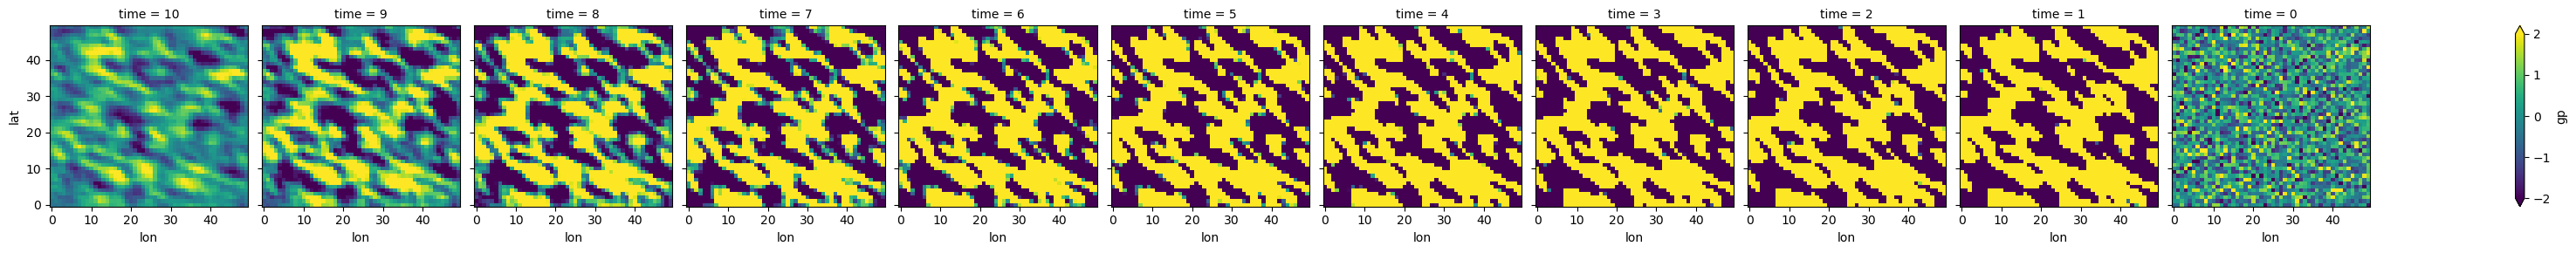

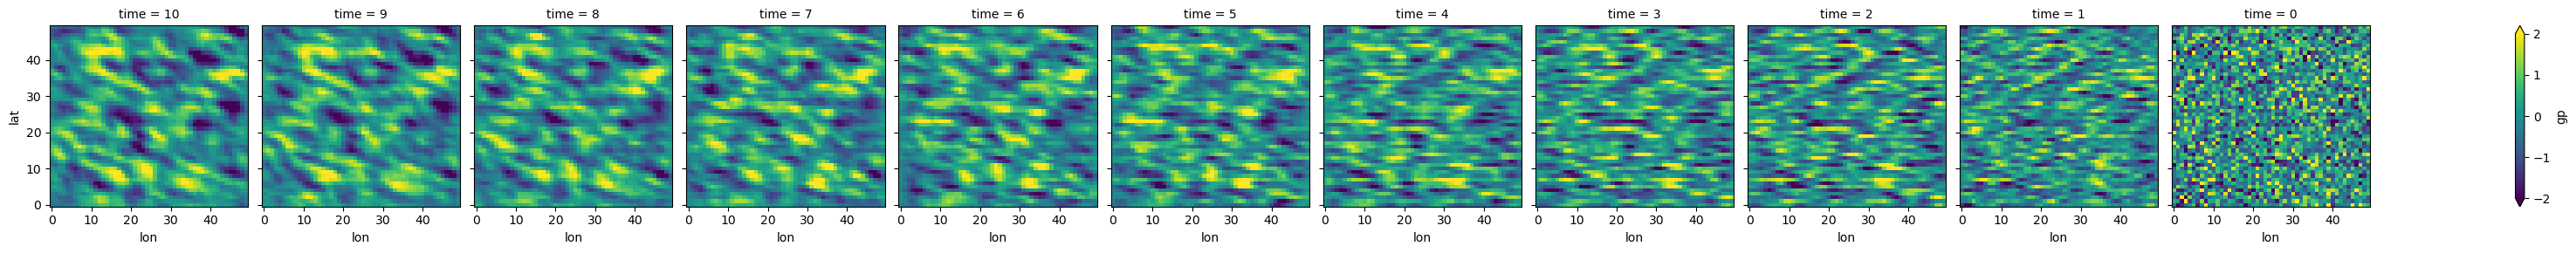

In [15]:
data_new = xr.Dataset(coords={'lon':np.arange(50),'lat':np.arange(50),'time':np.arange(nsteps,-1,-1)},
                  data_vars={'gp':(('time','lat','lon'),np.reshape(Z_all_new.numpy(),(nsteps+1,50,50)))})
data_new.gp.plot(col='time',col_wrap=nsteps+1,vmin=-2,vmax=2)
data.reindex(time=list(reversed(data.time))).gp.plot(col='time',col_wrap=nsteps+1,vmin=-2,vmax=2)


In [15]:
from IPython.display import Image
Image(url='mygif.gif')  

In [42]:
Z_data_all = torch.empty(Z_all.shape)
Z_data_all[:] = np.nan

idD = []

for i in range(10):
  plt.cla()
  indexes_dat = []
  for j in range(Ny):
        indexes_dat.extend(( np.arange((Nx*(j-1))+10+j+(10*np.mod(i,Nx)),
                             (((Nx*(j-1))+10+j+(10*np.mod(i,Nx))+4))) ))
        indexes_dat.extend(( np.arange((Nx*(j-1))+10-j-(10*np.mod(i,Nx)),
                             (((Nx*(j-1))+10-j-(10*np.mod(i,Nx))-4))) ))
      
  indexes_dat = np.array(indexes_dat)
  id= np.unique(np.where( (indexes_dat<(Nx*Ny)) & (indexes_dat>=0) )[0])
  indexes_dat=indexes_dat[id]
  idD.append(indexes_dat)
  Z_data_all[i,indexes_dat]=Z_all[i,indexes_dat]
  
  filename = f'{i}.png' 
  filenames.append(filename)
  # save frame
  plt.imshow(Z_data_all[i].numpy().reshape(Nx,Ny),vmin=-2,vmax=2)
  plt.savefig(filename)
  plt.close()

# build gif
with imageio.get_writer('mygif_data.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_25589/3835231477.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [10]:
from IPython.display import Image
Image(url='mygif_data.gif')  

In [11]:
def global_precision_matrix(diff_operator):

    Id = sparse_eye(nbNodes)
    M = Id+dt*diff_operator
    M = M.float()

    # case of right-hand side white noise
    QR = Id 

    # first line
    Qg = torch.hstack([spspmm(spspmm(M,M),QR),
                   -1.*spspmm(M,QR),
                   sparse_repeat(nbNodes,1,Nt-2)])
    # loop
    for i in np.arange(1,Nt-1):
        Qg_ = torch.hstack([sparse_repeat(nbNodes,1,i-1),
                    -1.*spspmm(M,QR),
                    spspmm(spspmm(M,M)+Id,QR),
                    -1.*spspmm(M,QR),
                    sparse_repeat(nbNodes,1,Nt-4-(i-2))])
        Qg  = torch.vstack([Qg,Qg_])
    # last line
    Qg_ = torch.hstack([sparse_repeat(nbNodes,1,Nt-2),
                              -1.*spspmm(M,QR),
                              spspmm(spspmm(M,M),QR)])
    Qg  = torch.vstack([Qg,Qg_])
    
    return Qg
                
Nt = 10
Qg = global_precision_matrix(A)

### Local anisotropy

\begin{eqnarray*}
(\kappa^2-\nabla \cdot H(\mathbf{s})\nabla)^{\frac{\alpha}{2}}\mathbf{x}(\mathbf{s})=\tau\mathcal{W}(\mathbf{s})
\end{eqnarray*}

(50, 50)


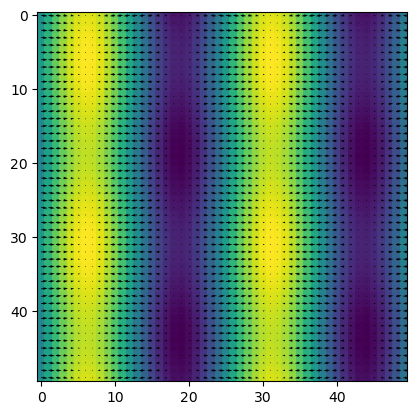

In [36]:
import matplotlib.pyplot as plt

def fxy(x,y):
 return( ((2*resolution)/np.pi)*( (3/4)*np.sin(2*np.pi*x/(5*resolution))) + (1/4)*np.sin(2*np.pi*y/(5*resolution) ))


x, y =np.meshgrid(range(Nx),range(Ny))
res=np.array(fxy(x,y))
plt.imshow(res)
grad=np.gradient(res)
u_=grad[0]
v_=grad[1]
print(u_.shape)

def rotate_vector(x1,y1,angle):
  x1_ = x1.flatten()
  y1_ = y1.flatten()
  x2_=np.cos(angle)*x1_-np.sin(angle)*y1_
  y2_=np.sin(angle)*x1_+np.cos(angle)*y1_
  return np.c_[x2_,y2_]

u=np.reshape(np.array(rotate_vector(u_,v_,-np.pi/2)[:,0],),(Nx,Ny))
v=np.reshape(np.array(rotate_vector(u_,v_,-np.pi/2)[:,1]),(Nx,Ny))
step_arrow=1
sel_x=np.tile(np.arange(0,Nx,step_arrow),Nx)
sel_y=np.tile(np.arange(0,Ny,step_arrow),Ny)
plt.quiver(x,y,u,v)

In [37]:
def Hs(u,v,gamma,beta):
  nNodes = u.shape[0]*u.shape[1]
  H=np.zeros((2,2,nNodes))
  cpt=0
  for i in range(u.shape[0]):
    for j in range(u.shape[1]):
      vs=np.r_[u[i,j],v[i,j]]
      Hs=(gamma*np.eye(2)) + beta*(vs @ vs.T)
      H[:,:,cpt]=Hs
      cpt=cpt+1
  return H

H_=torch.from_numpy(Hs(u,v,1,25))

\begin{eqnarray}
H(\mathbf{s})=\gamma \mathbf{I}_2 + \beta\left[\mathbf{v}(\mathbf{s}) \mathbf{v}(\mathbf{s})^\mathrm{T}\right]
\end{eqnarray}

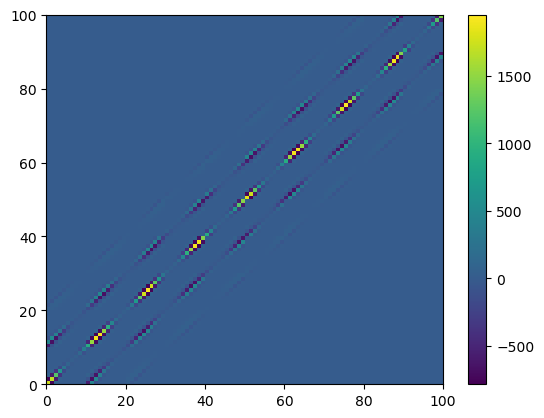

In [38]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def DiffOperator2(Nx, Ny, dx, dy, H, kappa):

    nbNodes = Nx * Ny

    indices = torch.arange(0,nbNodes)
    ## Voisin à droite Points de la grille concernés : Retrait du bord droit
    index = torch.where(torch.fmod(indices+1,Nx) != 0)[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k1 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + 1, (-1*H[0,0,indicesVoisins]/(dx**2)) ))
    ## Voisin à gauche Points de la grille concernés : Retrait du bord gauche
    index = torch.where(torch.fmod(indices+1,Nx) != 1)[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k2 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - 1, (-1*H[0,0,indicesVoisins]/(dx**2)) ))
    ## Voisin du haut Points de la grille concernés : Retrait du bord haut
    index = torch.where((indices+1) <= (Ny-1)*Nx )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k3 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx, (-1*H[1,1,indicesVoisins]/(dx**2)) ))
    ## Voisin du bas Points de la grille concernés : Retrait du bord bas
    index = torch.where((indices+1) >= (Nx+1) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k4 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx, (-1*H[1,1,indicesVoisins]/(dx**2)) ))
    ## Voisin en haut à droite Points de la grille concernés : Retrait du bord haut et droit
    index = torch.where( (torch.fmod(indices+1,Nx) != 0) & ((indices+1)<= (Ny-1)*Nx) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k5 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx+1, ((H[0,1,indicesVoisins]+H[1,0,indicesVoisins])/(4*dx*dy)) ))
    ## Voisin en haut à gauche Points de la grille concernés : Retrait du bord haut et gauche
    index = torch.where( (torch.fmod(indices+1,Nx) != 1) & ((indices+1)<= (Ny-1)*Nx) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k6 = torch.stack((indicesVoisins.double(), indicesVoisins.double() + Nx-1, (-1*(H[0,1,indicesVoisins]+H[1,0,indicesVoisins])/(4*dx*dy)) ))
    ## Voisin en bas à droite Points de la grille concernés : Retrait du bord bas et droit
    index = torch.where( (torch.fmod(indices+1,Nx) != 0) & ((indices+1)>=(Nx+1)) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k7 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx+1, (-1*(H[0,1,indicesVoisins]+H[1,0,indicesVoisins])/(4*dx*dy)) ))
    ## Voisin en bas à gauche Points de la grille concernés : Retrait du bord bas et gauche
    index = torch.where( (torch.fmod(indices+1,Nx) != 1) & ((indices+1)>=(Nx+1)) )[0]
    N=len(index)
    indicesVoisins = torch.index_select(indices,0,index)
    k8 = torch.stack((indicesVoisins.double(), indicesVoisins.double() - Nx-1, ((H[0,1,indicesVoisins]+H[1,0,indicesVoisins])/(4*dx*dy)) ))
    ## Point central
    N=len(indices)
    k9 = torch.stack((indices.double(), indices.double(), (kappa**2 + 2*(H[0,0,indices]/(dx**2) + H[1,1,indices]/(dy**2))) ))
    ## Tous les voisins
    k = torch.cat((k1, k2, k3, k4, k5, k6, k7, k8, k9),dim=1)
    return(torch.sparse.FloatTensor(k[0:2].long(), k[2], torch.Size([nbNodes,nbNodes])))

#### Test de la fonction
A=DiffOperator2(10,10,1,1,H=H_,kappa=1/3)
B=spspmm(A,A)
B=(1./2)*(B+B.t())
plt.pcolormesh(B.to_dense().numpy())
plt.colorbar()

In [39]:
from IPython import display
%matplotlib inline


A=DiffOperator2(Nx,Ny,dx,dy,H=H_,kappa=1./3)
A=DiffOperator(Nx,Ny,dx,dy,torch.tensor(np.array([[1,1],[1,1]])),0.33)
B=spspmm(A,A)
B=(1./2)*(B+B.t())

#### Décomposition de Cholesky de la matrice du système linéaire
L = Scipy_SolveCholesky.apply(A,dt)
Achol = torch.tensor(np.dot(L.to_dense().numpy(),np.transpose(L.to_dense().numpy())))

/tmp/ipykernel_14063/2631307156.py:30: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  AspChol = cholesky(A,ordering_method="natural")


In [40]:
# Initialisation
Z_all = [torch.randn(nbNodes)]

filenames = []
for i in range(100):
    plt.cla()
    Z_all = run_simulation(i,Z_all)
    filename = f'{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)
    plt.close()
    
# build gif
with imageio.get_writer('mygif2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
    
Z_all = torch.stack(Z_all[1:],dim=0)

/tmp/ipykernel_14063/610882976.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [41]:
from IPython.display import Image
Image(url='mygif2.gif') 

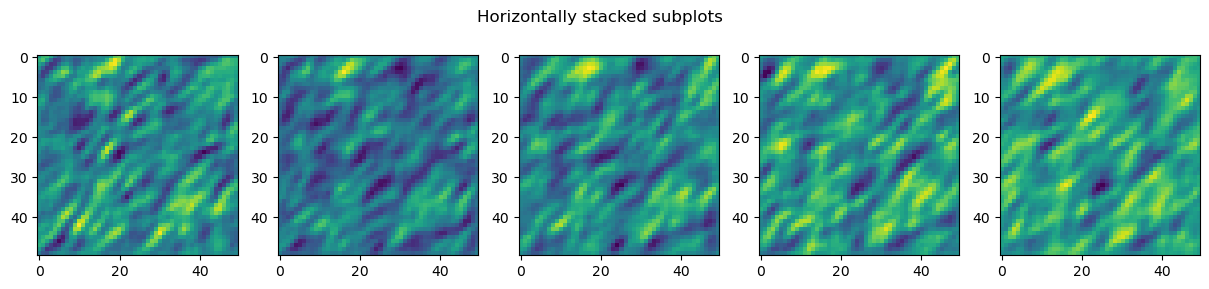

In [42]:
nbIter = 10

# Initialisation
Z_all = []

Id = sparse_eye(nbNodes)
M = Id+dt*B
M = M.to_dense()

def reverse_process(i,xt):
  #### Calcul du second membre
  RM = sqrt(dt/(dx*dy))*rnorm.sample((nbNodes,))+xt
  xtp1 = torch.linalg.solve(M.to_dense().float(),
                            RM.float())
  return xtp1

xtp1 = rnorm.sample((nbNodes,))
for i in range(nbIter):
    xtp1 = reverse_process(i,xtp1)
    Z_all.append(xtp1) 
        
Z_all = torch.stack(Z_all[1:])

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Horizontally stacked subplots')
axs[0].imshow(torch.reshape(Z_all[0,:],(50,50)))
axs[1].imshow(torch.reshape(Z_all[1,:],(50,50)))
axs[2].imshow(torch.reshape(Z_all[2,:],(50,50)))
axs[3].imshow(torch.reshape(Z_all[3,:],(50,50)))
axs[4].imshow(torch.reshape(Z_all[4,:],(50,50)))

In [55]:
snr = 1e-1

xt = rnorm.sample((nbNodes,))
B_ = B.to_dense().float()
for i in range(500):
    grad = torch.matmul(torch.matmul(B_.t(),B_),xt)
    grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
    noise_norm = np.sqrt(np.prod(xt.shape[0:]))
    langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
    xt = xt + langevin_step_size*torch.matmul(torch.matmul(B_.t(),B_),xt) + torch.sqrt(2*langevin_step_size)*rnorm.sample((nbNodes,))


tensor(-0.0046) tensor(1.0219)
tensor(-0.0045) tensor(1.0547)
tensor(-0.0046) tensor(1.0852)
tensor(-0.0045) tensor(1.1139)
tensor(-0.0047) tensor(1.1407)
tensor(-0.0046) tensor(1.1664)
tensor(-0.0044) tensor(1.1909)
tensor(-0.0044) tensor(1.2146)
tensor(-0.0043) tensor(1.2376)
tensor(-0.0043) tensor(1.2597)
tensor(-0.0043) tensor(1.2815)
tensor(-0.0041) tensor(1.3025)
tensor(-0.0042) tensor(1.3230)
tensor(-0.0041) tensor(1.3431)
tensor(-0.0042) tensor(1.3628)
tensor(-0.0042) tensor(1.3819)
tensor(-0.0042) tensor(1.4006)
tensor(-0.0043) tensor(1.4191)
tensor(-0.0043) tensor(1.4373)
tensor(-0.0041) tensor(1.4551)
tensor(-0.0042) tensor(1.4727)
tensor(-0.0042) tensor(1.4899)
tensor(-0.0043) tensor(1.5069)
tensor(-0.0043) tensor(1.5237)
tensor(-0.0044) tensor(1.5401)
tensor(-0.0043) tensor(1.5565)
tensor(-0.0043) tensor(1.5726)
tensor(-0.0043) tensor(1.5884)
tensor(-0.0044) tensor(1.6041)
tensor(-0.0044) tensor(1.6197)
tensor(-0.0046) tensor(1.6350)
tensor(-0.0045) tensor(1.6501)
tensor(-

tensor(-0.0047) tensor(3.6724)
tensor(-0.0047) tensor(3.6785)
tensor(-0.0047) tensor(3.6845)
tensor(-0.0047) tensor(3.6906)
tensor(-0.0048) tensor(3.6967)
tensor(-0.0048) tensor(3.7027)
tensor(-0.0047) tensor(3.7087)
tensor(-0.0048) tensor(3.7148)
tensor(-0.0048) tensor(3.7208)
tensor(-0.0048) tensor(3.7268)
tensor(-0.0048) tensor(3.7328)
tensor(-0.0048) tensor(3.7388)
tensor(-0.0048) tensor(3.7447)
tensor(-0.0048) tensor(3.7507)
tensor(-0.0048) tensor(3.7566)
tensor(-0.0048) tensor(3.7626)
tensor(-0.0048) tensor(3.7685)
tensor(-0.0048) tensor(3.7744)
tensor(-0.0048) tensor(3.7803)
tensor(-0.0048) tensor(3.7862)
tensor(-0.0048) tensor(3.7922)
tensor(-0.0048) tensor(3.7980)
tensor(-0.0048) tensor(3.8039)
tensor(-0.0049) tensor(3.8098)
tensor(-0.0049) tensor(3.8156)
tensor(-0.0049) tensor(3.8215)
tensor(-0.0048) tensor(3.8273)
tensor(-0.0049) tensor(3.8331)
tensor(-0.0049) tensor(3.8389)
tensor(-0.0049) tensor(3.8447)
tensor(-0.0049) tensor(3.8506)
tensor(-0.0048) tensor(3.8563)
tensor(-

tensor([[-1.3959],
        [ 0.4110],
        [-0.2012],
        ...,
        [-2.2772],
        [ 1.1521],
        [ 0.3588]])


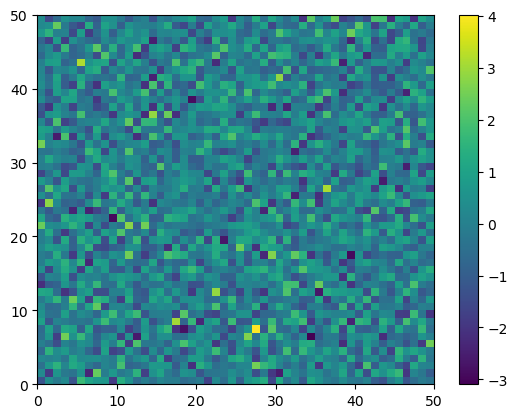

In [54]:
print(xt)
mean, std, var = torch.mean(xt), torch.std(xt), torch.var(xt)
plt.pcolormesh(torch.reshape((xt-mean)/std,(50,50)))
plt.colorbar()